In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate, integrate
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
eSOH_DIR = "../data/esoh_R/"
oCV_DIR = "../data/ocv/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_paper/"
res_DIR = "../data/results_paper/"
resistance_DIR = "../data/resistance/"

%matplotlib widget

In [2]:
# parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)

parameter_values = get_parameter_values()

spm = pybamm.lithium_ion.SPM()
spme = pybamm.lithium_ion.SPMe()

spmt = pybamm.lithium_ion.SPM(
    {
        "thermal": "lumped",
    }
)

spmet = pybamm.lithium_ion.SPMe(
    {
        "thermal": "lumped",
    }
)

dfn = pybamm.lithium_ion.DFN()

dfnt = pybamm.lithium_ion.DFN(
    {
        "thermal": "lumped",
    }
)
# spm.print_parameter_info()

## Setup

In [3]:
cell = 1+1*3
c_rate_c ='1.5C'
c_rate_d ='1.5C'
# Temp = -3.5
# Temp = 45
Temp = 25

x = [3.27585612, 5.31668278, 2.96095657, 3.46826355]

h = 1

pybamm.set_logging_level("NOTICE")

experiment = pybamm.Experiment(
    [
        (
        #  "Rest for 10 minutes", 
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
        #  "Rest for 20 minutes",
         )
    ],
    termination="50% capacity",
    period = "10 sec",
#     cccv_handling="ode",
)

experiment = pybamm.Experiment(
    [
        "Discharge at "+c_rate_d+" until 3V",
        "Rest for 10 sec",
        "Charge at "+c_rate_c+" until 4.2V", 
        "Hold at 4.2V until C/100",
        # "Rest for 10 sec",
        # "Discharge at "+c_rate_d+dis_set,
    ],
    period="10 sec",
)

SOC_0 = 0.98

In [4]:
parameter_values.update(
        {
            "Negative tab width [m]":2.5e-2,
            "Positive tab width [m]":2.5e-2,
            "Initial temperature [K]": 273.15+Temp,
            "Ambient temperature [K]": 273.15+Temp,
            # "Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]": 0.2*3.183e-06,
            # "Positive electrode reference exchange-current density [A.m-2(m3.mol)1.5]": 0.2*3.377e-06,
            # "Negative electrode diffusion coefficient [m2.s-1]": 0.3*8e-14,
            # "Positive electrode diffusion coefficient [m2.s-1]": 0.3*8e-15,
            #  "Positive electrode reference exchange-current density activation energy [J.mol-1]": 0,
            # "Positive electrode diffusion coefficient activation energy [J.mol-1]": 0,
            # "Negative electrode reference exchange-current density activation energy [J.mol-1]": 0,
            # "Negative electrode diffusion coefficient activation energy [J.mol-1]": 0,
            "Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]": 3.183e-06,#x[0]*
            "Positive electrode reference exchange-current density [A.m-2(m3.mol)1.5]":	3.377e-06,#x[1]*
            "Negative electrode diffusion coefficient [m2.s-1]": 8e-14,#x[2]*
            "Positive electrode diffusion coefficient [m2.s-1]": 8e-15,#x[3]*
            # "Negative electrode diffusion coefficient activation energy [J.mol-1]":35e3,
            # "Negative electrode reference exchange-current density activation energy [J.mol-1]": 20e3,
            # "Positive electrode diffusion coefficient activation energy [J.mol-1]": 25e3,
            # "Positive electrode reference exchange-current density activation energy [J.mol-1]": 30e3,
            "Negative electrode diffusion coefficient activation energy [J.mol-1]":x[0]*10e3,
            "Negative electrode reference exchange-current density activation energy [J.mol-1]": x[1]*10e3,
            "Positive electrode diffusion coefficient activation energy [J.mol-1]": x[2]*10e3,
            "Positive electrode reference exchange-current density activation energy [J.mol-1]": x[3]*10e3,
            "Edge heat transfer coefficient [W.m-2.K-1]":h,
            "Total heat transfer coefficient [W.m-2.K-1]":h,
            "Negative current collector surface heat transfer coefficient [W.m-2.K-1]": h,
            "Positive current collector surface heat transfer coefficient [W.m-2.K-1]": h,
            "Negative tab heat transfer coefficient [W.m-2.K-1]":h,
            "Positive tab heat transfer coefficient [W.m-2.K-1]":h,
            # "Negative electrode specific heat capacity [J.kg-1.K-1]": 1100*Cp,
            # "Positive electrode specific heat capacity [J.kg-1.K-1]": 1100*Cp,
            "Positive electrode OCP entropic change [V.K-1]":0,
            "Negative electrode OCP entropic change [V.K-1]":0,
        },
        check_already_exists=False,
    )


In [5]:
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution1 = sol_long

sim_long = pybamm.Simulation(spmt, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution2 = sol_long

2023-03-15 15:36:28.307 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/4 (8.884 ms elapsed) --------------------
2023-03-15 15:36:28.308 - [NOTICE] callbacks.on_step_start(182): Cycle 1/4, step 1/1: Discharge at 1.5C until 3V
2023-03-15 15:36:28.535 - [NOTICE] callbacks.on_cycle_start(174): Cycle 2/4 (236.725 ms elapsed) --------------------
2023-03-15 15:36:28.536 - [NOTICE] callbacks.on_step_start(182): Cycle 2/4, step 1/1: Rest for 10 sec
2023-03-15 15:36:28.586 - [NOTICE] callbacks.on_cycle_start(174): Cycle 3/4 (287.902 ms elapsed) --------------------
2023-03-15 15:36:28.587 - [NOTICE] callbacks.on_step_start(182): Cycle 3/4, step 1/1: Charge at 1.5C until 4.2V
2023-03-15 15:36:28.695 - [NOTICE] callbacks.on_cycle_start(174): Cycle 4/4 (397.107 ms elapsed) --------------------
2023-03-15 15:36:28.696 - [NOTICE] callbacks.on_step_start(182): Cycle 4/4, step 1/1: Hold at 4.2V until C/100
2023-03-15 15:36:28.851 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simul

In [6]:
sim_long = pybamm.Simulation(spme, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution3 = sol_long

sim_long = pybamm.Simulation(spmet, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution4 = sol_long


2023-03-15 15:36:34.441 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/4 (8.890 ms elapsed) --------------------
2023-03-15 15:36:34.442 - [NOTICE] callbacks.on_step_start(182): Cycle 1/4, step 1/1: Discharge at 1.5C until 3V
2023-03-15 15:36:34.780 - [NOTICE] callbacks.on_cycle_start(174): Cycle 2/4 (347.743 ms elapsed) --------------------
2023-03-15 15:36:34.780 - [NOTICE] callbacks.on_step_start(182): Cycle 2/4, step 1/1: Rest for 10 sec
2023-03-15 15:36:34.875 - [NOTICE] callbacks.on_cycle_start(174): Cycle 3/4 (443.185 ms elapsed) --------------------
2023-03-15 15:36:34.876 - [NOTICE] callbacks.on_step_start(182): Cycle 3/4, step 1/1: Charge at 1.5C until 4.2V
2023-03-15 15:36:35.078 - [NOTICE] callbacks.on_cycle_start(174): Cycle 4/4 (646.162 ms elapsed) --------------------
2023-03-15 15:36:35.079 - [NOTICE] callbacks.on_step_start(182): Cycle 4/4, step 1/1: Hold at 4.2V until C/100
2023-03-15 15:36:35.479 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simul

In [7]:
sim_long = pybamm.Simulation(dfn, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution5 = sol_long

sim_long = pybamm.Simulation(dfnt, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution6 = sol_long

2023-03-15 15:36:47.834 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/4 (13.805 ms elapsed) --------------------
2023-03-15 15:36:47.835 - [NOTICE] callbacks.on_step_start(182): Cycle 1/4, step 1/1: Discharge at 1.5C until 3V
2023-03-15 15:36:48.600 - [NOTICE] callbacks.on_cycle_start(174): Cycle 2/4 (779.214 ms elapsed) --------------------
2023-03-15 15:36:48.601 - [NOTICE] callbacks.on_step_start(182): Cycle 2/4, step 1/1: Rest for 10 sec
2023-03-15 15:36:48.867 - [NOTICE] callbacks.on_cycle_start(174): Cycle 3/4 (1.047 s elapsed) --------------------
2023-03-15 15:36:48.868 - [NOTICE] callbacks.on_step_start(182): Cycle 3/4, step 1/1: Charge at 1.5C until 4.2V
2023-03-15 15:36:49.481 - [NOTICE] callbacks.on_cycle_start(174): Cycle 4/4 (1.660 s elapsed) --------------------
2023-03-15 15:36:49.482 - [NOTICE] callbacks.on_step_start(182): Cycle 4/4, step 1/1: Hold at 4.2V until C/100
2023-03-15 15:36:49.959 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation

In [8]:
def load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no):
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    cycles = np.array(dfe_0['N'].astype('int'))+1
    cycles = cycles[1:]
    # print(cell_no)
    cyc_data_raw1 = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
    if cell == 1:
        offset = 12
    # elif cell == 9:
    #     offset = 2
    else:
        offset = 0
    if len(cycles) == cyc_no+1:
        N1 = cyc_data_raw1["Cycle number"].iloc[-1]-offset
    else:
        N1 = cycles[cyc_no]
    # print(N1)
    cyc_data_raw = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == N1 ]
    cyc_data = cyc_data_raw.reset_index(drop=True)
    t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
    t_c1 = t_c1.values
    I_c1 = cyc_data['Current [mA]']/1000
    I_c1 = I_c1.values
    V_c1 = cyc_data['Voltage [V]']
    V_c1 = V_c1.values
    E_c1 = cyc_data["Expansion [mu m]"]
    E_c1 = E_c1.values
    T_c1 = cyc_data["Temperature [C]"]
    T_c1 = T_c1.values
    idx_I = np.where(np.sign(I_c1[:-1]) != np.sign(I_c1[1:]))[0] 
    idx_I = idx_I[idx_I>50]
    t = t_c1[:idx_I[0]]
    V = V_c1[:idx_I[0]]
    I = I_c1[:idx_I[0]]
    E = E_c1[:idx_I[0]]-E_c1[0]
    T = T_c1[:idx_I[0]]
    # t = t_c1
    # V = V_c1
    # I = I_c1
    Q = integrate.cumtrapz(I,t, initial=0)/3600 #Ah
    
    return t,V,I,Q,E,T


In [9]:
def plot_vars(solution):
    t_t =  solution["Time [s]"].entries
    t_t = t_t/3600
    V_t =  solution["Terminal voltage [V]"].entries
    I_t =  solution["Current [A]"].entries
    Q_t = -solution['Discharge capacity [A.h]'].entries
    T_t = solution['X-averaged cell temperature [K]'].entries
    T_t = T_t-273.15
    idx = np.where(np.diff(np.sign(-I_t)))[0]
    I = I_t[idx[0]:]
    t = t_t[idx[0]:]-t_t[idx[0]]
    Q = Q_t[idx[0]:]-Q_t[idx[0]]
    V = V_t[idx[0]:]
    T = T_t[idx[0]:]
    return t,V,I,Q,T

In [10]:
# spm.variables.search("temperature")

In [11]:
cyc_no = 0
t_d,V_d,I_d,Q_d,E_d,T_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)

In [12]:
t1,V1,I1,Q1,T1 = plot_vars(solution1)
t2,V2,I2,Q2,T2 = plot_vars(solution2)
t3,V3,I3,Q3,T3 = plot_vars(solution3)
t4,V4,I4,Q4,T4 = plot_vars(solution4)
t5,V5,I5,Q5,T5 = plot_vars(solution5)
t6,V6,I6,Q6,T6 = plot_vars(solution6)

## Plots

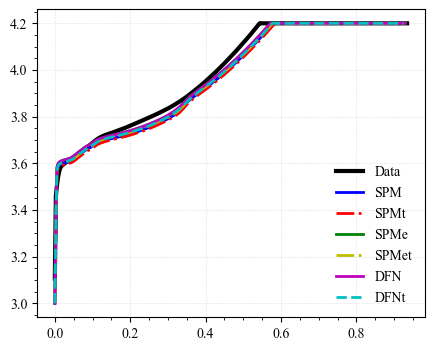

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax1 = ax
ax1.plot(t_d/3600,V_d,'k',linewidth="3")
ax1.plot(t1,V1,'b')
ax1.plot(t2,V2,'r-.')
ax1.plot(t3,V3,'g')
ax1.plot(t4,V4,'y-.')
ax1.plot(t5,V5,'m')
ax1.plot(t6,V6,'c--')

ax1.legend(["Data","SPM","SPMt","SPMe","SPMet","DFN","DFNt"])

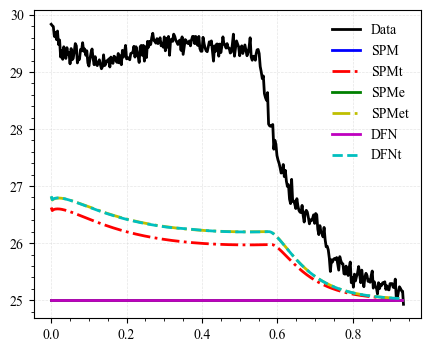

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax1 = ax
ax1.plot(t_d/3600,T_d,'k')
ax1.plot(t1,T1,'b')
ax1.plot(t2,T2,'r-.')
ax1.plot(t3,T3,'g')
ax1.plot(t4,T4,'y-.')
ax1.plot(t5,T5,'m')
ax1.plot(t6,T6,'c--')
ax1.legend(["Data","SPM","SPMt","SPMe","SPMet","DFN","DFNt"])

In [15]:
sdsds

NameError: name 'sdsds' is not defined

In [ ]:
parameter_values.update(
        {
            "Positive electrode OCP entropic change [V.K-1]":0,
            "Negative electrode OCP entropic change [V.K-1]":0,
        },
        check_already_exists=False,
    )

sim_long = pybamm.Simulation(spmet, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution9 = sol_long

sim_long = pybamm.Simulation(dfnt, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution10 = sol_long

t9,V9,I9,Q9,T9 = plot_vars(solution9)
t10,V10,I10,Q10,T10 = plot_vars(solution10)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax1 = ax
ax1.plot(t_d/3600,V_d,'k',linewidth="3")
ax1.plot(t9,V9,'b')
ax1.plot(t10,V10,'r-.')
ax1.plot(t3,V3,'g')
ax1.plot(t4,V4,'y-.')
ax1.plot(t5,V5,'m')
ax1.plot(t6,V6,'c--')

ax1.legend(["Data","SPMet No Entropic","DFNt No Entropic","SPMe","SPMet","DFN","DFNt"])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax1 = ax
ax1.plot(t_d/3600,T_d,'k')
ax1.plot(t9,T9,'b')
ax1.plot(t10,T10,'r-.')
ax1.plot(t3,T3,'g')
ax1.plot(t4,T4,'y-.')
ax1.plot(t5,T5,'m')
ax1.plot(t6,T6,'c--')
ax1.legend(["Data","SPMet No Entropic","DFNt No Entropic","SPMe","SPMet","DFN","DFNt"])

In [ ]:
sdfsdfs

In [ ]:
experiment = pybamm.Experiment(
    [
        "Discharge at "+c_rate_d+" until 3V",
        "Rest for 10 sec",
        "Charge at "+c_rate_c+" until 4.2V", 
        "Hold at 4.2V until C/100",
        # "Rest for 10 sec",
        # "Discharge at "+c_rate_d+dis_set,
    ]*10,
    period="10 sec",
)

In [ ]:
sim_long = pybamm.Simulation(spmt, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution7 = sol_long

sim_long = pybamm.Simulation(spmet, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution8 = sol_long

In [ ]:
t7,V7,I7,Q7,T7 = plot_vars(solution7)
t8,V8,I8,Q8,T8 = plot_vars(solution8)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax1 = ax
ax1.plot(t7,T7,'b')
ax1.plot(t8,T8,'r-.')
# ax1.legend(["Data","SPM","SPMt","SPMe","SPMet","DFN","DFNt"])

In [ ]:
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
cyc_data_raw1 = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax1 = ax
ax1.plot(cyc_data_raw1["Time [s]"],cyc_data_raw1["Temperature [C]"],'k')
# ax1.legend(["Data","SPM","SPMt","SPMe","SPMet","DFN","DFNt"])

In [ ]:
asdasd